# Génération de données vraisemblables

Dans ce notebook, on utilise le modèle BM-SEIR pour générer des données vraisemblables. Les fonctions nécessaires à la génération des données sont passées dans un fichier externe, 'utilities.py' pour éviter d'alourdir le notebook. 

In [1]:
% run 'utilities.py'

#### Sauvegarder les données générées de manière satisfaisante (et les seed qui vont avec !)

In [2]:
import pandas as pd

# Importation des données 
data = pd.read_csv("H1N1-London-2009-master/data/data.csv")
data.head()

,date,London__HPA__inc
0,2009-06-01,0.4893
1,2009-06-08,1.4171
2,2009-06-15,3.9675
3,2009-06-22,15.4217
4,2009-06-29,25.9461


In [3]:
import datetime as dt

# Convertir la date au format datetime
dates = data.date.values
data["date"] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
data.head()

,date,London__HPA__inc
0,2009-06-01,0.4893
1,2009-06-08,1.4171
2,2009-06-15,3.9675
3,2009-06-22,15.4217
4,2009-06-29,25.9461


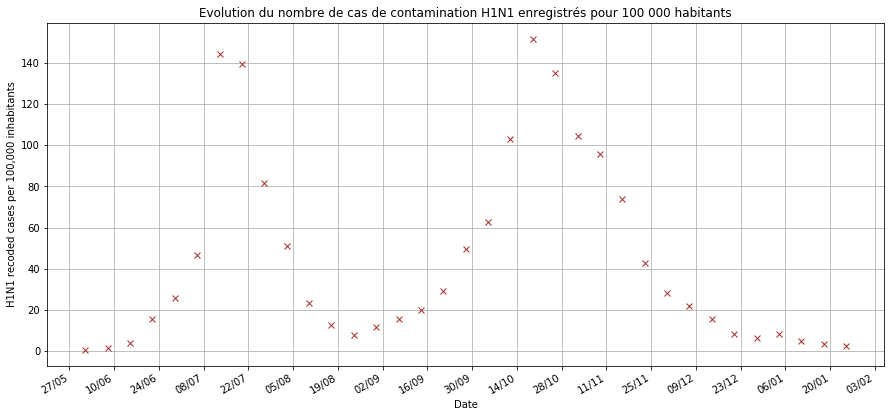

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot

# Paramètres visuels
kwargs = {'alpha' : 0.99, 'c': 'brown', 'marker' : 'x'}

# Visualisation
fig, ax = plt.subplots(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.plot_date(data.date,data.London__HPA__inc, **kwargs)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("H1N1 recoded cases per 100,000 inhabitants")
plt.title("Evolution du nombre de cas de contamination H1N1 enregistrés pour 100 000 habitants")

plt.show()

In [5]:
import random

# Valeurs pour reproduire une trajectoire vaguement ressemblante: 
# Seed : 22
# Paramètres : mu, sigma, gamma = 0., 0.2, 4.
# Variance pour le BM : sigma_x = .5
# Conditions initiales : S0, E0, I0, R0 = 0.9, 0.0, 0.1, 0.
# Ne pas hésiter à faire tourner le générateur de données plusieurs fois pour qu'il génère une observation
# assez "haute" sur le deuxième pic.

np.random.seed(22)

In [6]:
import sdeint
import numpy as np
import math

# Simulation des données

# Paramètres
mu, sigma, gamma = 0., 0.2, 4.

# Variance pour le BM
sigma_x = .5

# Vecteur temporel
t = np.linspace(0, 50, 10000)

# Conditions initiales
S0, E0, I0, R0 = 0.9, 0.0, 0.1, 0.
y0 = np.array([S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

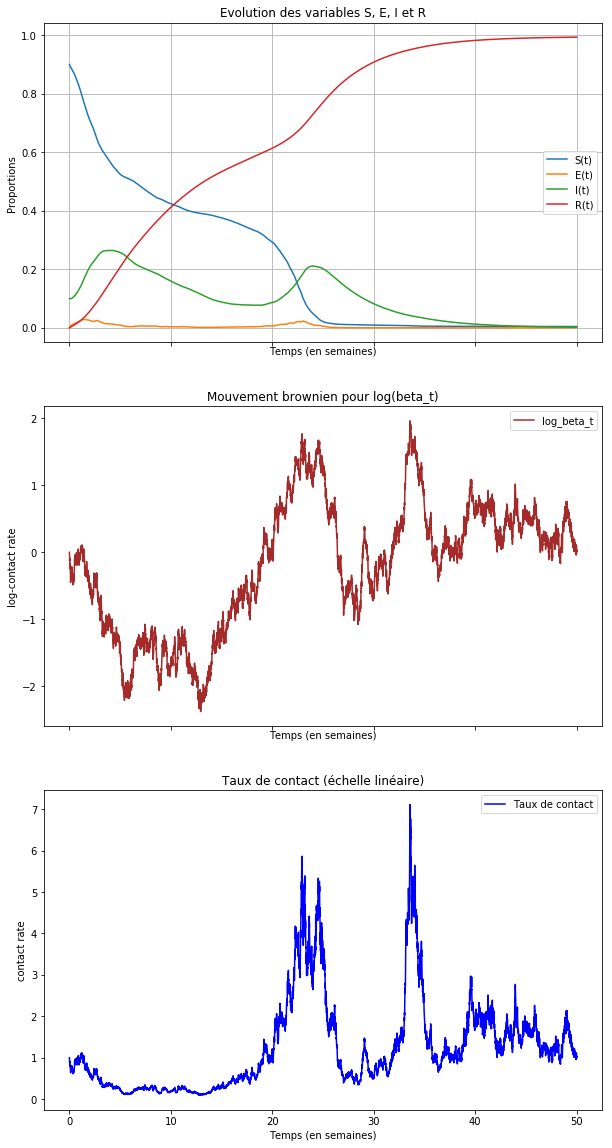

In [8]:
# Affichage de la trajectoire simulée
plot_realisation(result, t, {}, {}, {}, (10,20))

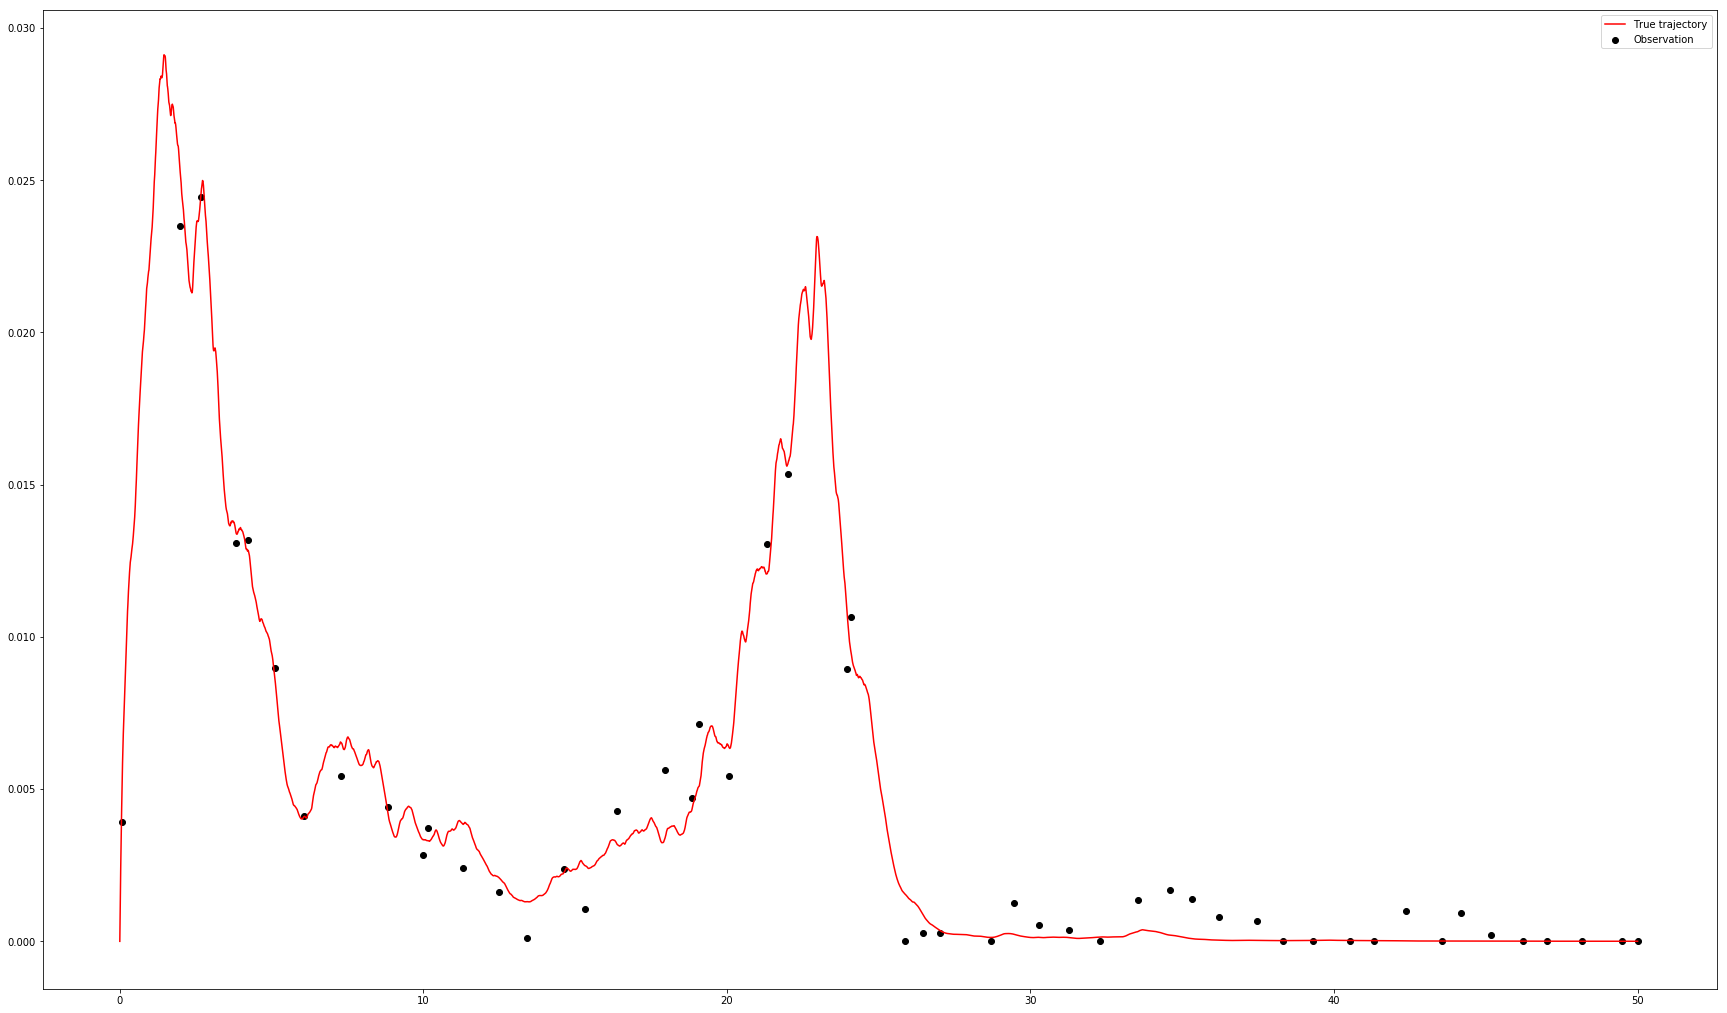

In [10]:
# Observations aléatoires pour E_t (on prend le nombre de nouveaux cas, pas nécessairement infectieux.)
I_t = result[:,1]
vals, indices = generate_noisy_incidence(I_t, .001, 1, t)

plt.plot(t, I_t, c = "red", label = "True trajectory")
plt.scatter(t[indices], vals, c = 'black', label = "Observation")
plt.legend()

plt.rcParams["figure.figsize"] = (30,18)
plt.show()

In [11]:
# Maintenant qu'on a généré une tendance assez similaire (double pic)
# On les retravaille pour que cela ressemble un peu plus aux données de base

data.London__HPA__inc.describe()

count     35.000000
mean      44.207154
std       46.561858
min        0.489300
25%        8.338100
50%       23.268500
75%       68.248500
max      151.738600
Name: London__HPA__inc, dtype: float64

In [12]:
import statistics as stat

# Changement d'échelle

vals =[ math.exp(i*100)**1.4 - 1 for i in vals]

In [13]:
# Stocker ces valeurs dans une DataFrame
fake_data = pd.DataFrame()
fake_data["date"] = data.date
fake_data["incidence"] = vals[:35] # On retient les 35 premiers points pour matcher avec les vraies données

In [14]:
fake_data.incidence.describe()

count    35.000000
mean      2.853964
std       6.501902
min       0.000000
25%       0.177206
50%       0.730703
75%       2.103340
max      29.644768
Name: incidence, dtype: float64

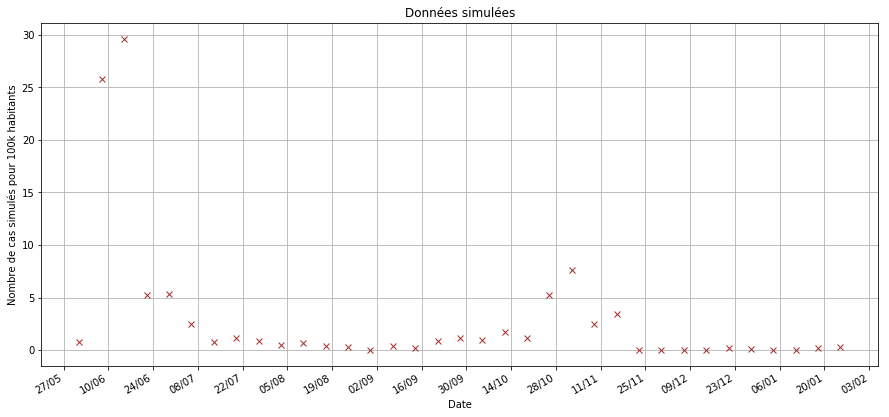

In [15]:
# Plot

# Paramètres visuels
kwargs = {'alpha' : 0.99, 'c': 'brown', 'marker' : 'x'}

# Visualisation
fig, ax = plt.subplots(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.plot_date(fake_data.date,fake_data.incidence, **kwargs)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Nombre de cas simulés pour 100k habitants")
plt.title("Données simulées")

plt.show()



In [16]:
# Exporter le .csv

fake_data.to_csv("generative_data.csv", header = True)

##  Données simulées discrétisées

Dans cette section, on simule des observations conformément aux indications de l'annexe C du papier. Concrètement, on suppose que $\beta_t$ suit une marche aléatoire avec une volatilité $\sigma^2 = .07^2$. Le bruit des observations est fixé à $\tau = 0.1$ ou $\tau = 0.05$. Deux jeux de données sont simulés, pour chacune des valeurs de $\tau$. Pour l'implémentation, on réduit la finesse du pas de temps.

In [17]:
import sdeint
import numpy as np
import math

# Simulation des données
np.random.seed(42)

# Paramètres
mu, sigma, gamma = 0., 0.01, .2

# Variance pour le BM
sigma_x = .07

# Vecteur temporel
t = np.linspace(0, 50, 50) # Pour passer à une RW, 50 pas de temps uniquement

# Conditions initiales
S0, E0, I0, R0 = 0.7, 0.0, 0.3, 0.
y0 = 10**.5 * np.array( [S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

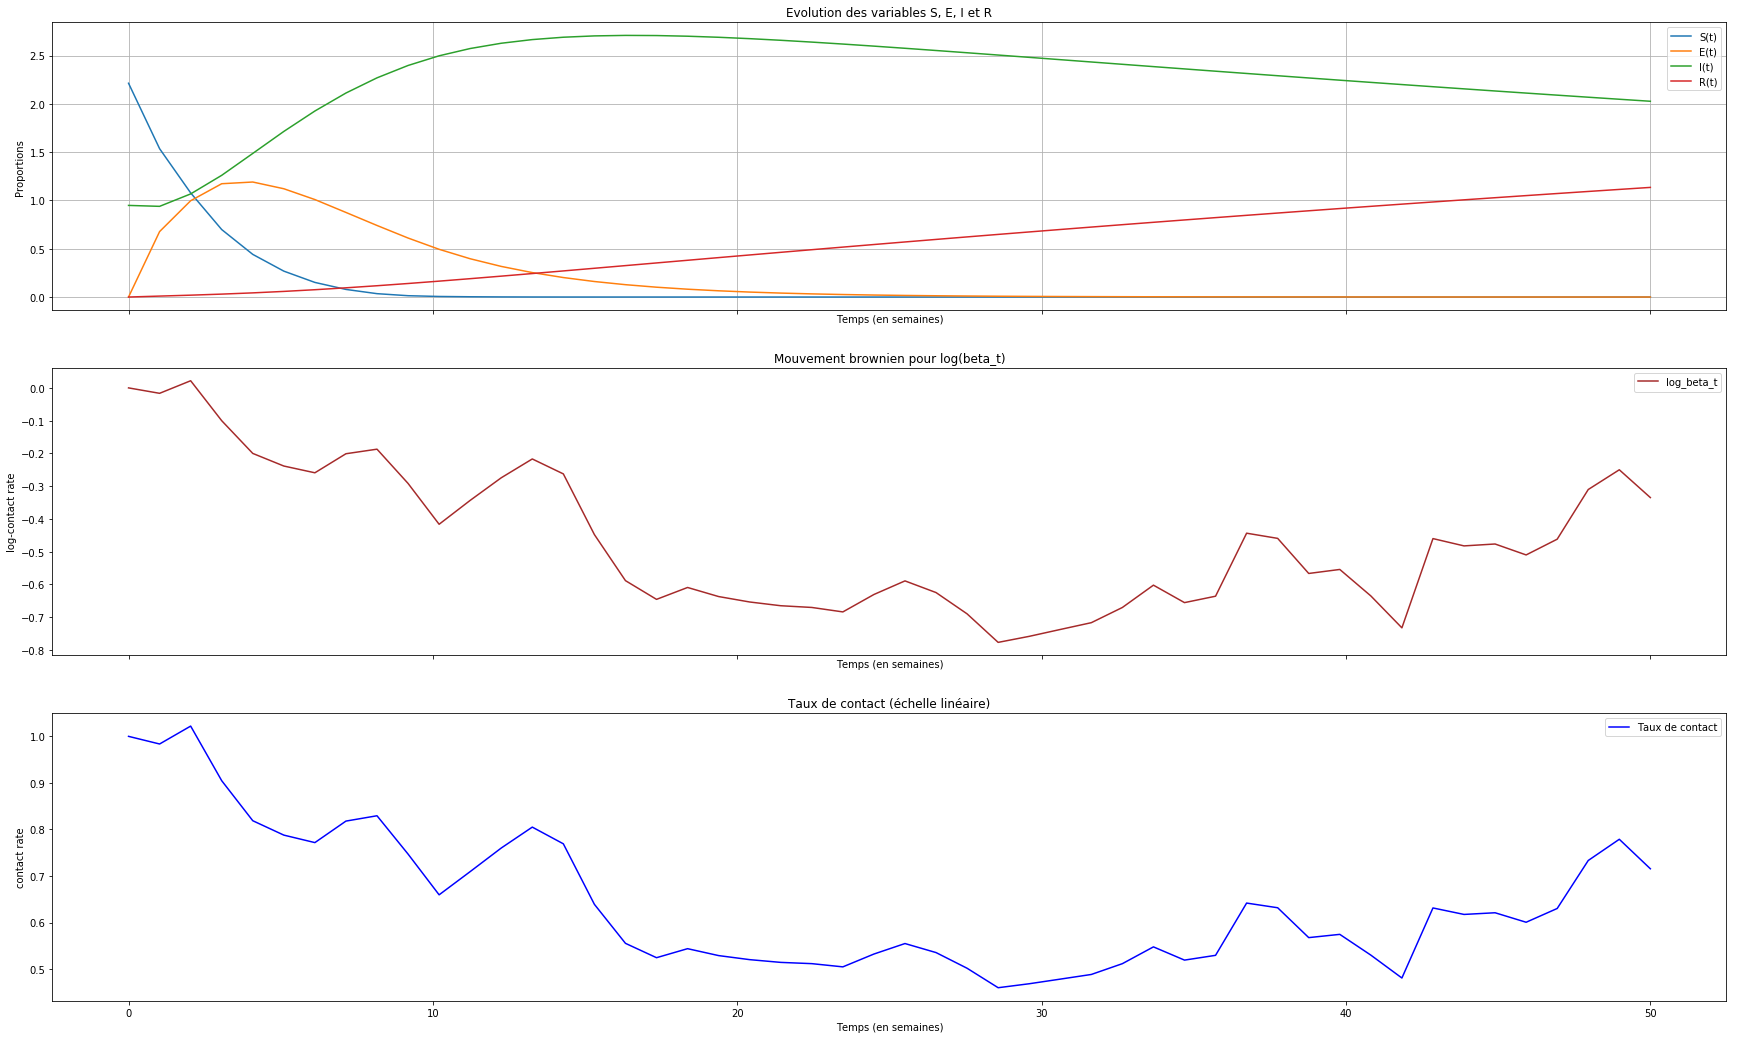

In [18]:
# Affichage de la trajectoire simulée
plot_realisation(result, t, {}, {}, {}, (10,20))

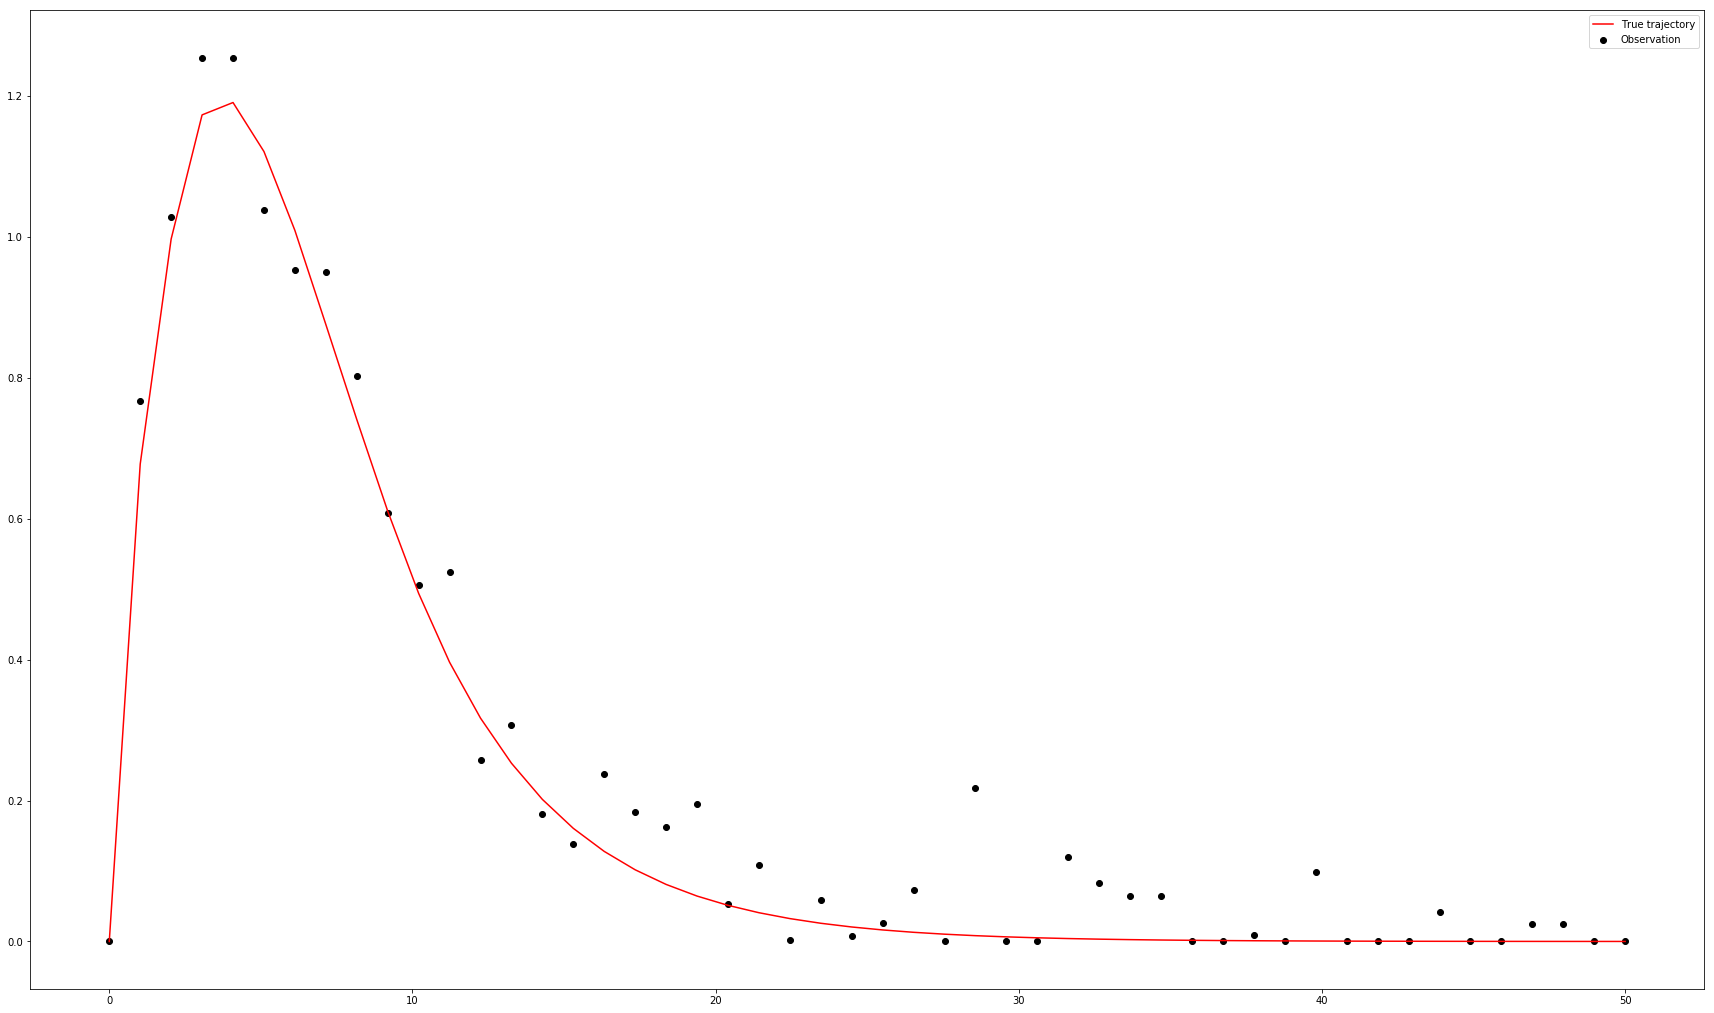

In [20]:
# Génération de fausses données

# Observations aléatoires pour E_t (on prend le nombre de nouveaux cas, pas nécessairement infectieux.)
I_t = result[:,1]
vals, indices = generate_noisy_incidence(I_t, .1, 1, t) # Pour tau = .1

plt.plot(t, I_t, c = "red", label = "True trajectory")
plt.scatter(t[indices], vals, c = 'black', label = "Observation")
plt.legend()

plt.rcParams["figure.figsize"] = (30,18)
plt.show()

In [21]:
# Exporter le .csv
# Stocker ces valeurs dans une DataFrame
fake_data = pd.DataFrame()
fake_data["date"] = range(1,len(vals)+1)
fake_data["incidence"] = vals

fake_data.to_csv("discrete_0_1_generative_data.csv", header = True)

In [22]:
# Pour tau = .05

# Génération de fausses données

# Observations aléatoires pour E_t (on prend le nombre de nouveaux cas, pas nécessairement infectieux.)
I_t = result[:,1]
vals, indices = generate_noisy_incidence(I_t, .05, 1, t) # Pour tau = .1

# Stocker ces valeurs dans une DataFrame
fake_data = pd.DataFrame()
fake_data["date"] = range(1,len(vals)+1)
fake_data["incidence"] = vals

fake_data.to_csv("discrete_0_0_5_generative_data.csv", header = True)


## Prévalence

Dans cette section, on reprend le modèle en temps "continu" et on s'intéresse à une autre quantité : la prévalence, qui correspond au "stock" de malades dans la population. On a donc
$Prev_t = Prev_{t-1} + E_t - R_t$

In [23]:
import random

np.random.seed(100)

In [24]:
import sdeint
import numpy as np
import math

# Simulation des données

# Paramètres
mu, sigma, gamma = 0., 0.03, .04

# Variance pour le BM
sigma_x = .7

# Vecteur temporel
t = np.linspace(0, 50, 10000)

# Conditions initiales
S0, E0, I0, R0 = 0.7, 0.0, 0.3, 0.
y0 = 10 ** 1 * np.array([S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

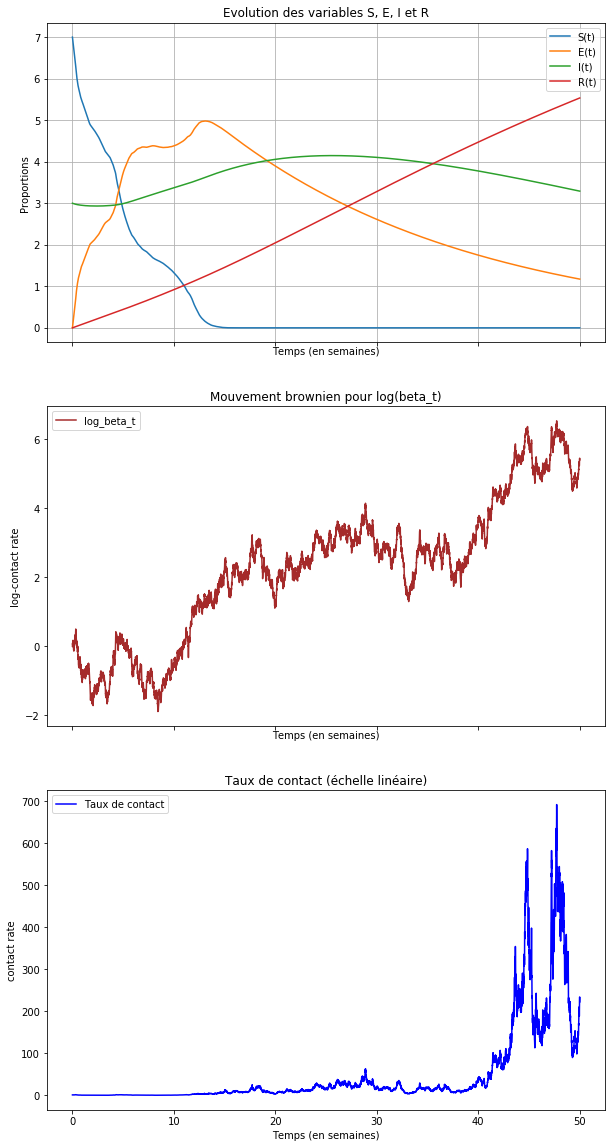

In [26]:
# Affichage de la trajectoire simulée
plot_realisation(result, t, {}, {}, {}, (10,20))

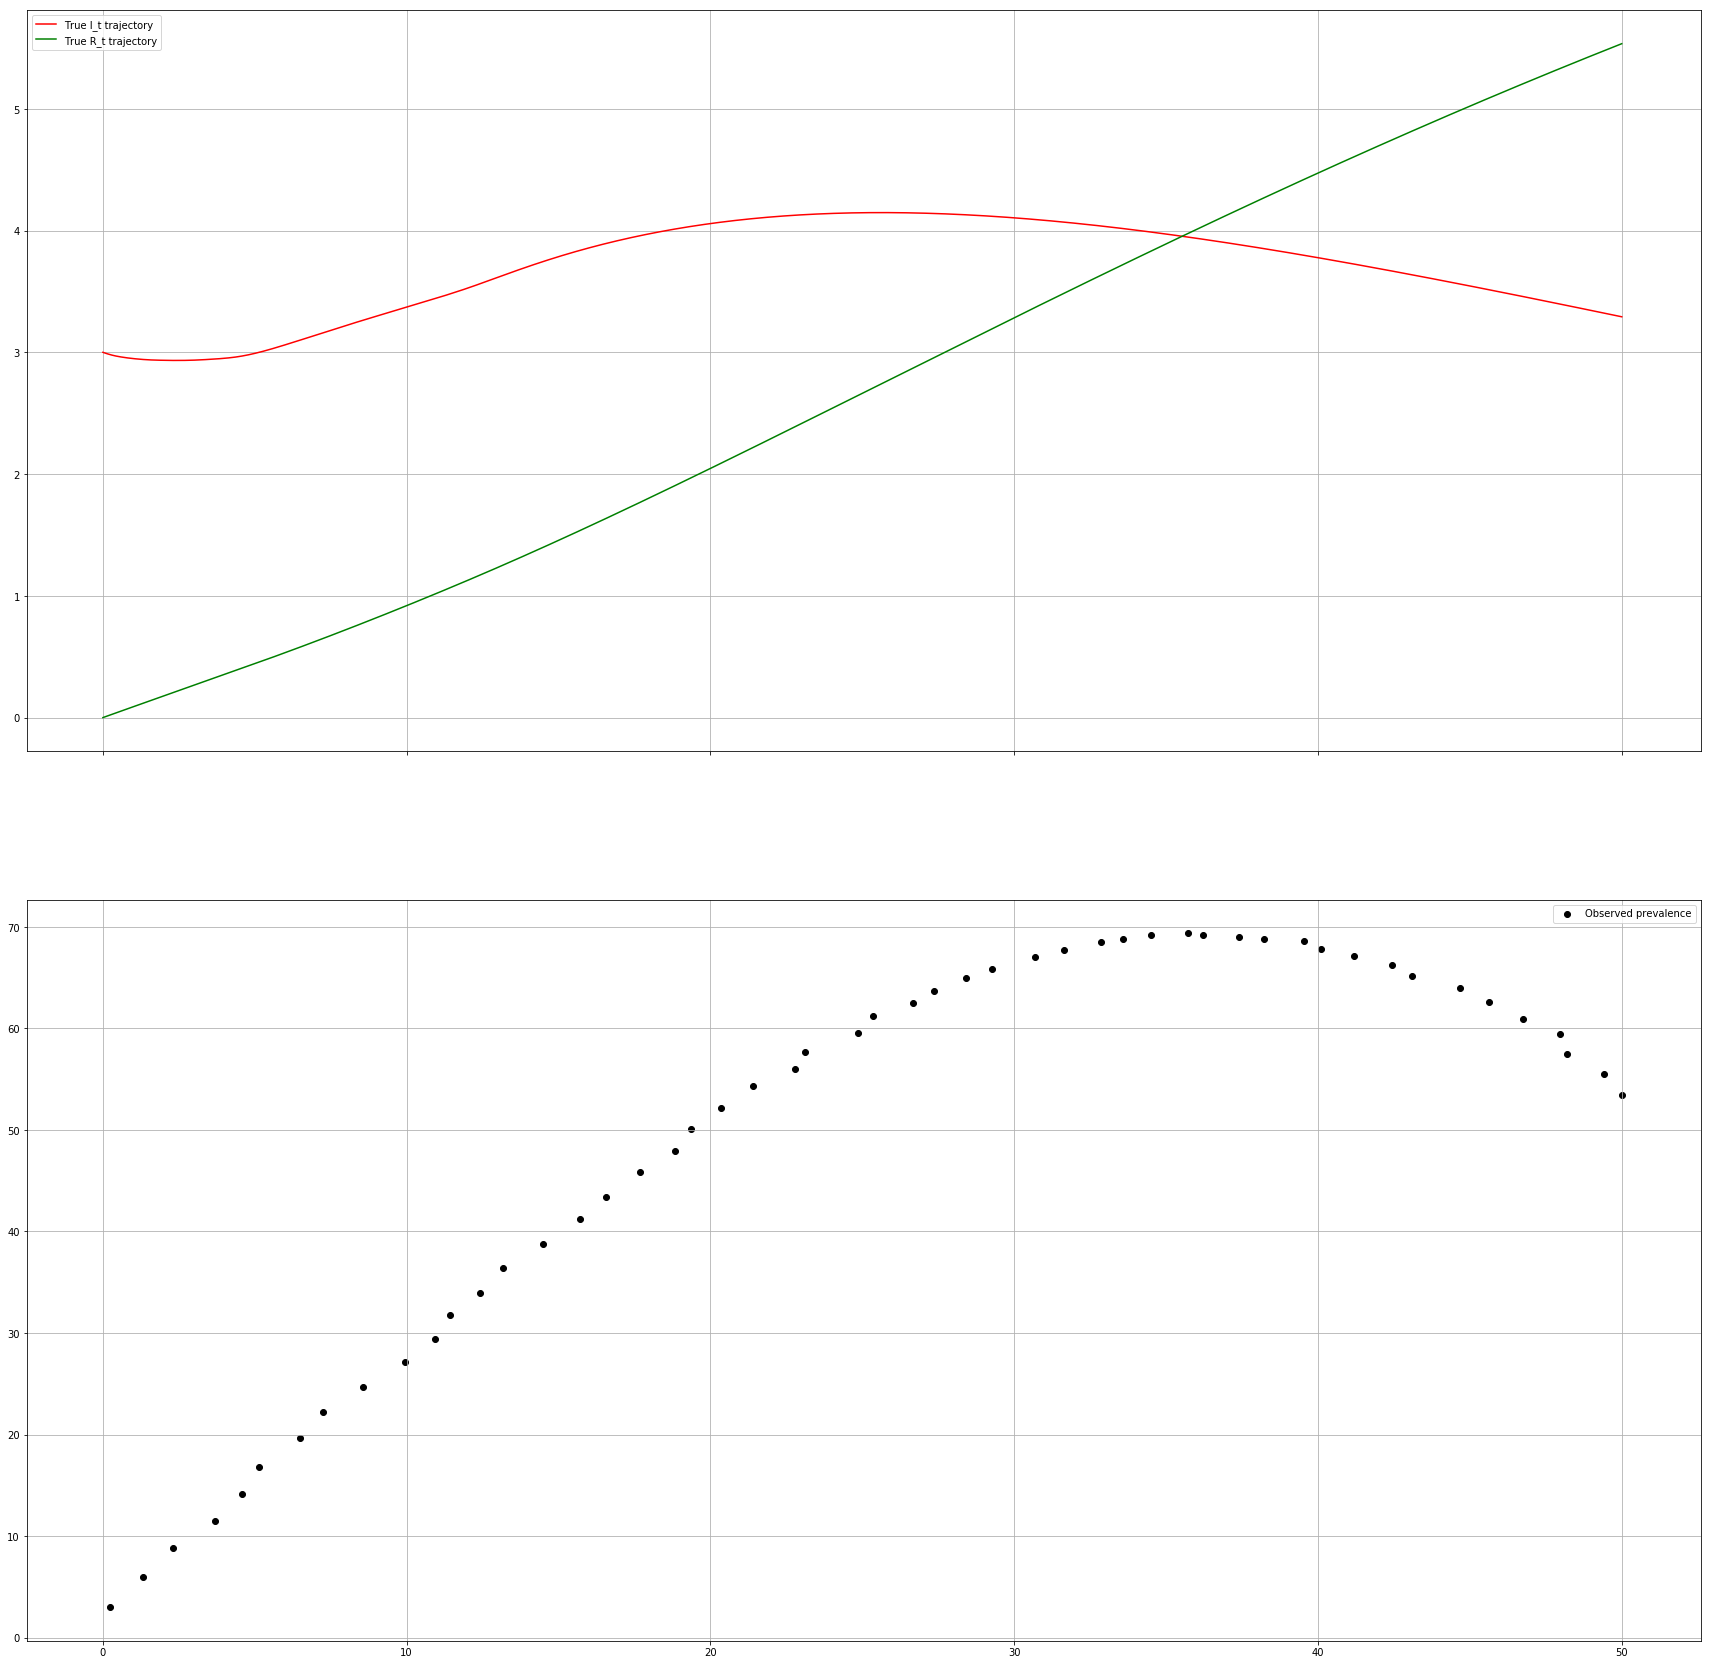

In [28]:
# Génération de fausses données
# Observations aléatoires pour E_t (on prend le nombre de nouveaux cas, pas nécessairement infectieux.)
E_t = result[:,2]
R_t = result[:,3]
vals, indices = generate_noisy_prevalence(E_t, R_t, .1, 1, t) # On prend tau = .1

fig, ((ax1, ax2)) = plt.subplots(2, sharex=True, sharey=False)

ax1.plot(t, E_t, c = "red", label = "True I_t trajectory")
ax1.plot(t, R_t, c = "green", label = "True R_t trajectory")
ax1.legend()
ax1.grid()
      
ax2.scatter(t[indices], vals, c = 'black', label = "Observed prevalence")
ax2.legend()
ax2.grid()

plt.rcParams["figure.figsize"] = (30,30)
plt.show()

In [29]:
# Exporter le .csv
# Stocker ces valeurs dans une DataFrame
fake_data = pd.DataFrame()
fake_data["date"] = range(1,len(vals)+1)
fake_data["incidence"] = vals

fake_data.to_csv("generative_prevalence.csv", header = True)

## Génération de données avec le vrai beta

In [30]:
# Ajout d'une option pour avoir It et la trajectoire de beta dans un csv.
# Les points pour beta sont donnés avec la même fréquence que les valeurs de I_t

## Simuler une trajectoire

import sdeint
import numpy as np
import math

# Simulation des données
np.random.seed(42)

# Paramètres
mu, sigma, gamma = 0., 0.01, .2

# Variance pour le BM
sigma_x = .07

# Vecteur temporel
t = np.linspace(0, 50, 50) # Pour passer à une RW, 50 pas de temps uniquement

# Conditions initiales
S0, E0, I0, R0 = 0.7, 0.0, 0.3, 0.
y0 = 10**.5 * np.array( [S0, E0, I0, R0, mu])


def simulate_stochastic_SEIR_model(y, t):
    # Déballer les valeurs initiales
    # Partie déterministe
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    # Partie stochastique
    x = y[4]
    
    # Population totale
    N = S + E + I + R
    
    # Equations du modèle
    dS_dt = - math.exp(y[4]) * S * I / N
    dE_dt = math.exp(y[4]) * S * I / N - gamma * E
    dI_dt = gamma * E - sigma * I
    dR_dt = sigma * I
    dx_dt = mu
    return np.array([dS_dt, dE_dt, dI_dt, dR_dt, dx_dt])


# Partie stochastique
def BM(y, t):
    return np.diag([0, 0, 0, 0, sigma_x])

# Résolution
result = sdeint.itoEuler(simulate_stochastic_SEIR_model, BM, y0, t)

## Bruiter les observations

# Pour tau = .05

# Génération de fausses données

# Observations aléatoires pour E_t (on prend le nombre de nouveaux cas, pas nécessairement infectieux.)
I_t = result[:,1]
vals, indices = generate_noisy_incidence(I_t, .05, 1, t) # Pour tau = .1

## Stocker les valeur et beta dans une dataframe
fake_data = pd.DataFrame()
fake_data["date"] = range(1,len(vals)+1)
fake_data["incidence"] = vals
fake_data["true_beta"] = result[:,4]

fake_data.to_csv("data_with_beta.csv", header = True)


In [32]:
visualize_with_beta = pd.read_csv("data_with_beta.csv")
visualize_with_beta.head()

,Unnamed: 0,date,incidence,true_beta
0,0,1,0.000000,0.000000
1,1,2,0.653884,-0.016557
2,2,3,0.964425,0.021808
3,3,4,1.261544,-0.100162
4,4,5,1.211083,-0.200027


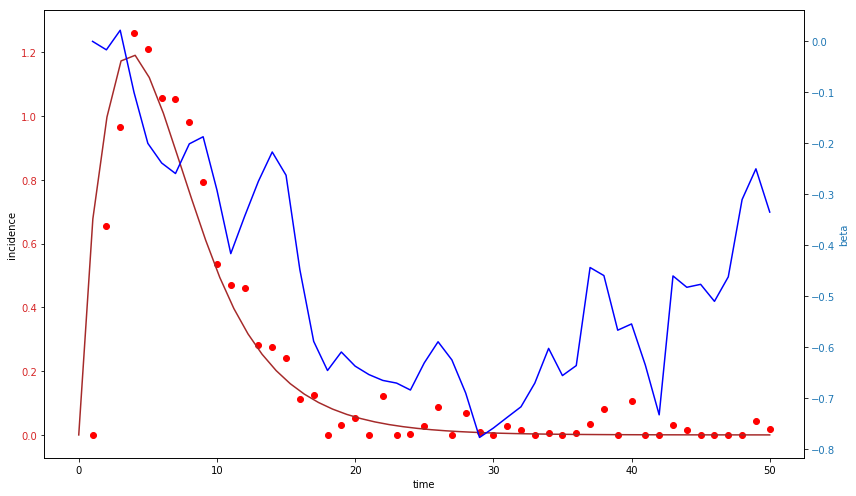

In [41]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('incidence')
ax1.scatter(visualize_with_beta["date"], visualize_with_beta["incidence"], c = "red")
ax1.plot(t, I_t, c = "brown")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('beta', color=color)  # we already handled the x-label with ax1
ax2.plot(visualize_with_beta["date"], visualize_with_beta["true_beta"], c = "blue")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.rcParams["figure.figsize"] = (12,7)
plt.show()